In [1]:
import torch
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import nn
from torch.optim import Adam

In [2]:
torch.manual_seed(42)
BATCH_SIZE= 32
transform = transforms.Compose([
    transforms.ToTensor()
])
train_dataset= MNIST(root= './data', train= True, download= True, transform= transform)
test_dataset= MNIST(root= './data', train= False, download= True, transform= transform)
train_loader= DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle= True)
test_loader= DataLoader(test_dataset, batch_size= BATCH_SIZE, shuffle= False)

In [3]:
len(train_dataset), len(test_dataset)

(60000, 10000)

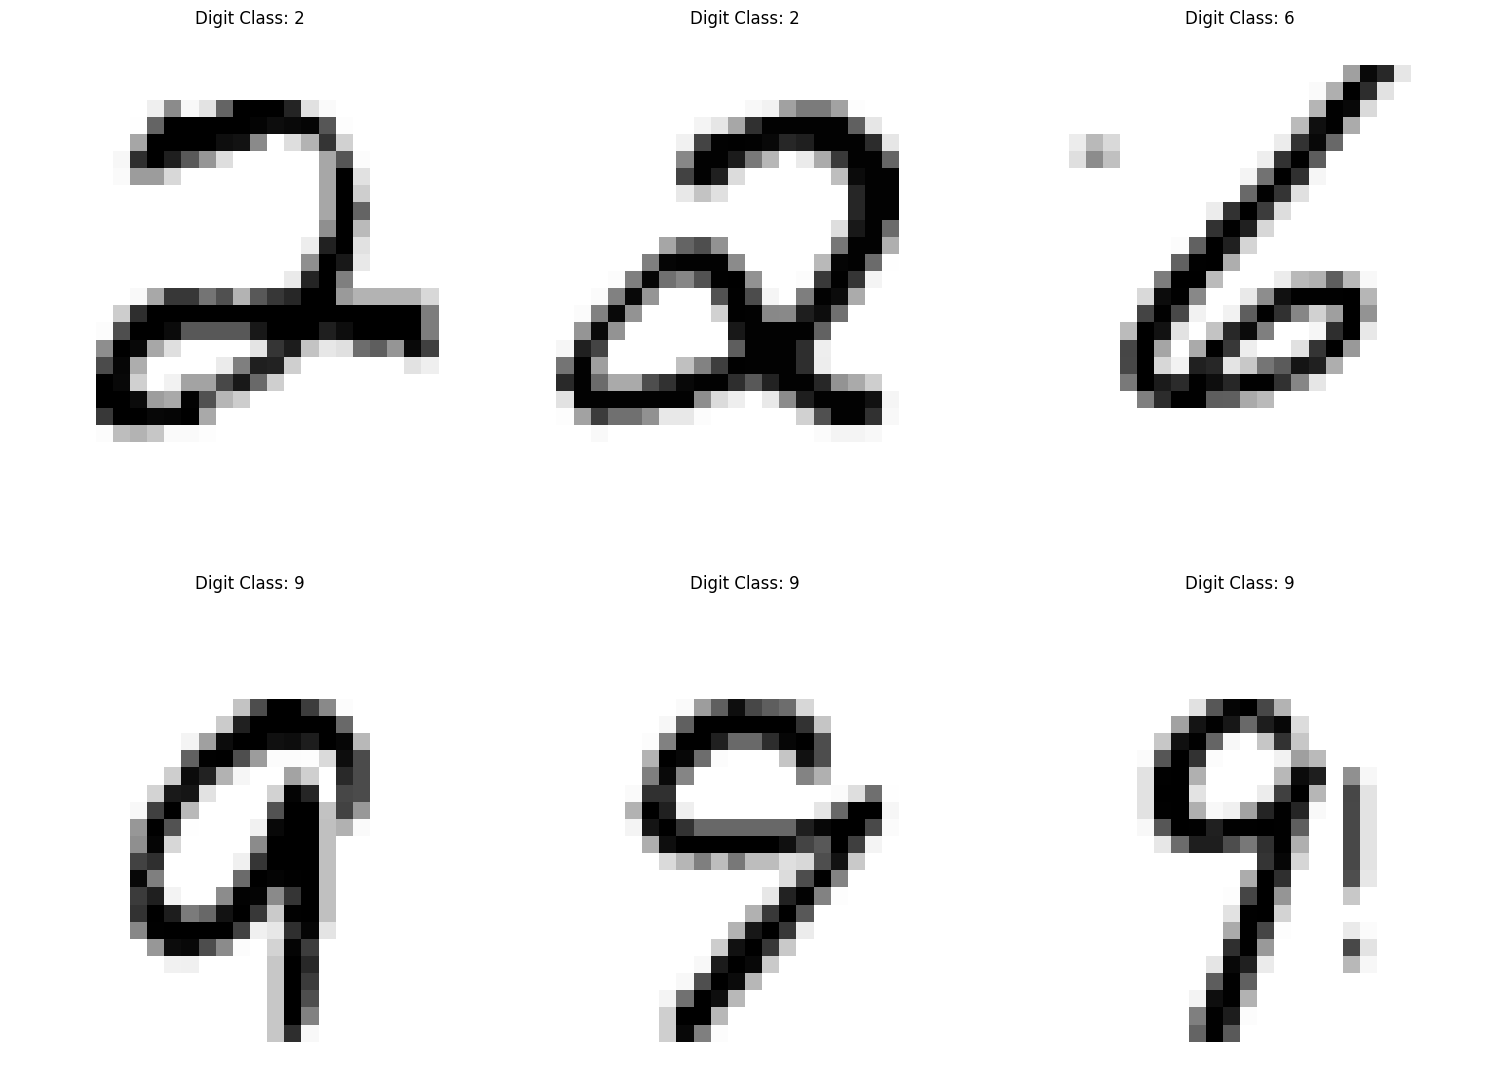

In [4]:
def display_images(images, labels, indices, n_rows= 2, n_cols= 3, figsize= (15,12)):
    fig, axes= plt.subplots(n_rows, n_cols, figsize= figsize)

    axes= axes.flatten()
    for i, idx in enumerate(indices):
        image= images[idx].numpy()
        label= labels[idx].item()

        axes[i].imshow(image.squeeze(), cmap= plt.cm.binary)
        axes[i].axis(False)
        axes[i].set_title(f"Digit Class: {label}")
    plt.tight_layout()
    plt.show()

images, labels= next(iter(train_loader))
indices= [1, 4, 5, 6, 7, 8]
display_images(images, labels, indices)

In [5]:
class ReLUMLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1= nn.Linear(784, 256) # Input Shape: 28x28= 784, Out Shape: 256
        self.relu1= nn.ReLU()

        self.fc2= nn.Linear(256, 128) # Input Shape: 256, Out Shape: 128
        self.relu2= nn.ReLU()


        self.output= nn.Linear(128, 10) # In Shape: 128, Outshape: num classes = 10

    def forward(self, x):

        x= x.view(x.size(0), -1)
        features= self.relu1(self.fc1(x))
        features= self.relu2(self.fc2(features))
        out_logits= self.output(features)

        return out_logits


In [6]:
class LeakyReLUMLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1= nn.Linear(784, 256) # Input Shape: 28x28= 784, Out Shape: 256
        self.leaky_relu1= nn.LeakyReLU()

        self.fc2= nn.Linear(256, 128) # Input Shape: 256, Out Shape: 128
        self.leaky_relu2= nn.LeakyReLU()


        self.output= nn.Linear(128, 10) # In Shape: 128, Outshape: num classes = 10

    def forward(self, x):

        x= x.view(x.size(0), -1)
        features= self.leaky_relu1(self.fc1(x))
        features= self.leaky_relu2(self.fc2(features))
        out_logits= self.output(features)

        return out_logits


In [7]:
class ELUMLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1= nn.Linear(784, 256) # Input Shape: 28x28= 784, Out Shape: 256
        self.elu1= nn.ELU()

        self.fc2= nn.Linear(256, 128) # Input Shape: 256, Out Shape: 128
        self.elu2= nn.ELU()


        self.output= nn.Linear(128, 10) # In Shape: 128, Outshape: num classes = 10

    def forward(self, x):

        x= x.view(x.size(0), -1)
        features= self.elu1(self.fc1(x))
        features= self.elu2(self.fc2(features))
        out_logits= self.output(features)

        return out_logits


In [8]:
class TanhMLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1= nn.Linear(784, 256) # Input Shape: 28x28= 784, Out Shape: 256
        self.tanh1= nn.Tanh()

        self.fc2= nn.Linear(256, 128) # Input Shape: 256, Out Shape: 128
        self.tanh2= nn.Tanh()


        self.output= nn.Linear(128, 10) # In Shape: 128, Outshape: num classes = 10

    def forward(self, x):

        x= x.view(x.size(0), -1)
        features= self.tanh1(self.fc1(x))
        features= self.tanh2(self.fc2(features))
        out_logits= self.output(features)

        return out_logits


In [9]:
def train_eval_model(model,
                     train_loader,
                     test_loader,
                     optimizer,
                     num_epochs,
                     device,
                     loss_fn
                     ):
    train_loss_history= []
    val_loss_history= []
    train_acc_history= []
    val_acc_history= []

    patience= 4
    epochs_without_improvement= 0
    min_delta= 0.01
    best_val_loss= 0.5

    for epoch in range(num_epochs):
        model.train()
        running_train_loss= 0.0
        train_correct= 0.0
        train_total= 0.0

        for images, labels in train_loader:
            images, labels= images.to(device), labels.to(device)
            preds= model(images)
            loss= loss_fn(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_train_loss+= loss

            # Calculate Training Accuracy
            _, predicted= torch.max(preds.data, 1)
            train_total+= labels.size(0)
            train_correct+= (predicted == labels).sum().item()

        model.eval()
        running_val_loss= 0.0
        val_correct= 0.0
        val_total= 0.0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels= images.to(device), labels.to(device)
                preds= model(images)
                loss= loss_fn(preds, labels)

                running_val_loss+= loss

                # Calculate Val Accuracy
                _, predicted= torch.max(preds.data, 1)
                val_total+= labels.size(0)
                val_correct+= (predicted == labels).sum().item()

        running_val_loss/= len(test_loader)

        if running_val_loss < best_val_loss - min_delta:
            best_val_loss= running_val_loss
            epochs_without_improvement= 0
        else:
            epochs_without_improvement+= 1

        running_train_loss/= len(train_loader)

        train_acc= (train_correct / train_total) * 100
        val_acc= (val_correct / val_total) * 100

        train_loss_history.append(running_train_loss.item())
        val_loss_history.append(running_val_loss.item())
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        print(f"Epoch {epoch + 1}/{num_epochs} ")
        print("-" * 10)
        print(f"Train Loss: {running_train_loss.item():.4f}")
        print(f"Train Accuracy: {train_acc:.2f}%")
        print(f"Val Loss: {running_val_loss.item():.4f}")
        print(f"Val Accuracy: {val_acc:.2f}%")
        print("-" * 50)

        # if epochs_without_improvement >= patience:
        #     print(f"Early stopping triggered at epoch {epoch + 1}. No improvement after {patience} epochs.")
        #     break
    epochs= [epoch for epoch in range(1, len(train_loss_history) + 1)]
    return {
        "epochs": epochs,
        "train_loss_history": train_loss_history,
        "val_loss_history": val_loss_history,
        "train_acc_history": train_acc_history,
        "val_acc_history": val_acc_history,
    }


In [10]:
torch.manual_seed(42)
LEARNING_RATE= 0.008
NUM_EPOCHS= 6
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_fn= nn.CrossEntropyLoss()

relu_model= ReLUMLP()
leakyrelu_model= LeakyReLUMLP()
elu_model= ELUMLP()
tanh_model= TanhMLP()


optimizer_relu= Adam(relu_model.parameters(), lr= LEARNING_RATE)
optimizer_leakyrelu= Adam(leakyrelu_model.parameters(), lr= LEARNING_RATE)
optimizer_elu= Adam(elu_model.parameters(), lr= LEARNING_RATE)
optimizer_tanh= Adam(tanh_model.parameters(), lr= LEARNING_RATE)

print(f"RELU Training Starting")
print(f"-"*80)
relu_model.to(device)
relu_model_metrics= train_eval_model(model= relu_model,
                                train_loader= train_loader,
                                test_loader= test_loader,
                                optimizer= optimizer_relu,
                                num_epochs= NUM_EPOCHS,
                                device= device,
                                loss_fn= loss_fn)
print(f"-"*80)
print(f"LeakyRELU Training Starting")
print(f"-"*80)
leakyrelu_model.to(device)
leakyrelu_model_metrics= train_eval_model(model= leakyrelu_model,
                                train_loader= train_loader,
                                test_loader= test_loader,
                                optimizer= optimizer_leakyrelu,
                                num_epochs= NUM_EPOCHS,
                                device= device,
                                loss_fn= loss_fn)
print(f"-"*80)
print(f"ELU Training Starting")
print(f"-"*80)
elu_model.to(device)
elu_model_metrics= train_eval_model(model= elu_model,
                                train_loader= train_loader,
                                test_loader= test_loader,
                                optimizer= optimizer_elu,
                                num_epochs= NUM_EPOCHS,
                                device= device,
                                loss_fn= loss_fn)
print(f"-"*80)
print(f"Tanh Training Starting")
print(f"-"*80)
tanh_model.to(device)
tanh_model_metrics= train_eval_model(model= tanh_model,
                                train_loader= train_loader,
                                test_loader= test_loader,
                                optimizer= optimizer_tanh,
                                num_epochs= NUM_EPOCHS,
                                device= device,
                                loss_fn= loss_fn)

print(f"-"*80)

RELU Training Starting
--------------------------------------------------------------------------------
Epoch 1/6 
----------
Train Loss: 0.2528
Train Accuracy: 92.59%
Val Loss: 0.1645
Val Accuracy: 95.24%
--------------------------------------------------
Epoch 2/6 
----------
Train Loss: 0.1689
Train Accuracy: 95.46%
Val Loss: 0.1420
Val Accuracy: 96.14%
--------------------------------------------------
Epoch 3/6 
----------
Train Loss: 0.1351
Train Accuracy: 96.40%
Val Loss: 0.1451
Val Accuracy: 96.30%
--------------------------------------------------
Epoch 4/6 
----------
Train Loss: 0.1271
Train Accuracy: 96.66%
Val Loss: 0.1567
Val Accuracy: 96.21%
--------------------------------------------------
Epoch 5/6 
----------
Train Loss: 0.1165
Train Accuracy: 96.94%
Val Loss: 0.1509
Val Accuracy: 96.41%
--------------------------------------------------
Epoch 6/6 
----------
Train Loss: 0.1065
Train Accuracy: 97.26%
Val Loss: 0.1757
Val Accuracy: 96.23%
-----------------------------

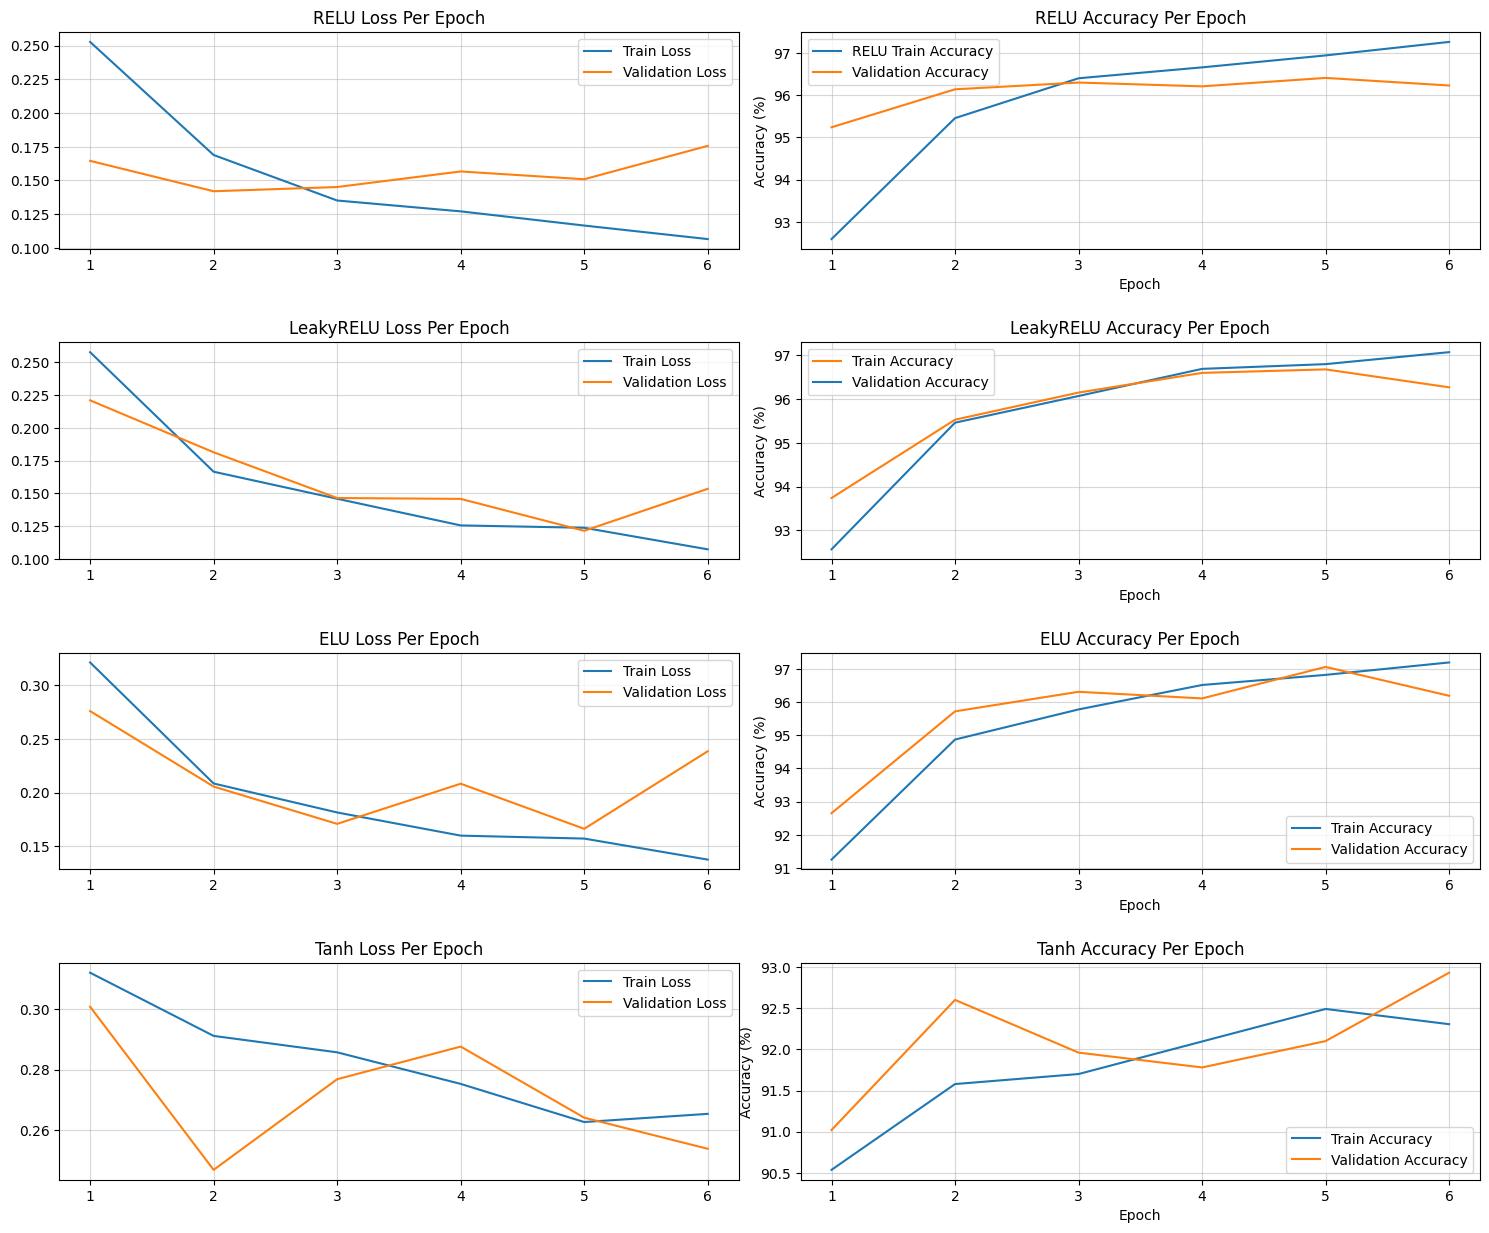

In [ ]:
fig= plt.figure(figsize= (15, 12))

# ReLU Figure
ax1= fig.add_subplot(421)
ax2= fig.add_subplot(422)

ax1.set_title("RELU Loss Per Epoch")
ax1.grid(True, alpha= 0.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
p1= ax1.plot(relu_model_metrics["epochs"], relu_model_metrics["train_loss_history"])
p2= ax1.plot(relu_model_metrics["epochs"], relu_model_metrics["val_loss_history"])
ax1.legend((p1[0], p2[0]), ('Train Loss', 'Validation Loss'))

ax2.set_title("RELU Accuracy Per Epoch")
ax2.grid(True, alpha= 0.5)
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
p3= ax2.plot(relu_model_metrics["epochs"], relu_model_metrics["train_acc_history"])
p4= ax2.plot(relu_model_metrics["epochs"], relu_model_metrics["val_acc_history"])
ax2.legend((p3[0], p4[0]), ('RELU Train Accuracy', 'Validation Accuracy'))
plt.grid(True)

# LeakyReLU Figure
ax3= fig.add_subplot(423)
ax4= fig.add_subplot(424)

ax3.set_title("LeakyRELU Loss Per Epoch")
ax3.grid(True, alpha= 0.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
p5= ax3.plot(leakyrelu_model_metrics["epochs"], leakyrelu_model_metrics["train_loss_history"])
p6= ax3.plot(leakyrelu_model_metrics["epochs"], leakyrelu_model_metrics["val_loss_history"])
ax3.legend((p5[0], p6[0]), ('Train Loss', 'Validation Loss'))

ax4.set_title("LeakyRELU Accuracy Per Epoch")
ax4.grid(True, alpha= 0.5)
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
p7= ax4.plot(leakyrelu_model_metrics["epochs"], leakyrelu_model_metrics["train_acc_history"])
p8= ax4.plot(leakyrelu_model_metrics["epochs"], leakyrelu_model_metrics["val_acc_history"])
ax4.legend((p2[0], p3[0]), ('Train Accuracy', 'Validation Accuracy'))

plt.grid(True)


# ELU Figure
ax5= fig.add_subplot(425)
ax6= fig.add_subplot(426)

ax5.set_title("ELU Loss Per Epoch")
ax5.grid(True, alpha= 0.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
p9= ax5.plot(elu_model_metrics["epochs"], elu_model_metrics["train_loss_history"])
p10= ax5.plot(elu_model_metrics["epochs"], elu_model_metrics["val_loss_history"])
ax5.legend((p9[0], p10[0]), ('Train Loss', 'Validation Loss'))

ax6.set_title("ELU Accuracy Per Epoch")
ax6.grid(True, alpha= 0.5)
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
p11= ax6.plot(elu_model_metrics["epochs"], elu_model_metrics["train_acc_history"])
p12= ax6.plot(elu_model_metrics["epochs"], elu_model_metrics["val_acc_history"])
ax6.legend((p11[0], p12[0]), ('Train Accuracy', 'Validation Accuracy'))
plt.grid(True)

# Tanh Figure
ax7= fig.add_subplot(427)
ax8= fig.add_subplot(428)

ax7.set_title("Tanh Loss Per Epoch")
ax7.grid(True, alpha= 0.5)
plt.xlabel("Epoch")
plt.ylabel("Loss")
p13= ax7.plot(tanh_model_metrics["epochs"], tanh_model_metrics["train_loss_history"])
p14= ax7.plot(tanh_model_metrics["epochs"], tanh_model_metrics["val_loss_history"])
ax7.legend((p13[0], p14[0]), ('Train Loss', 'Validation Loss'))

ax8.set_title("Tanh Accuracy Per Epoch")
ax8.grid(True, alpha= 0.5)
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
p15= ax8.plot(tanh_model_metrics["epochs"], tanh_model_metrics["train_acc_history"])
p16= ax8.plot(tanh_model_metrics["epochs"], tanh_model_metrics["val_acc_history"])
ax8.legend((p15[0], p16[0]), ('Train Accuracy', 'Validation Accuracy'))
fig.tight_layout(h_pad= 2.0)
plt.grid(True)

